In [ ]:
#| hide
#| eval: false
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#| hide
#| eval: false
!pip install -q nbdev

# data

> Fill in a module description here

In [ ]:
#| default_exp data

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from pathlib import Path
from fastai.basics import *

In [ ]:
#| notest
DATA_PATH  = Path('data').parent / 'drive' / 'MyDrive' / 'paathai' / 'data'
TRAIN_PCT  = 0.9

def load_data():
  with open(DATA_PATH / 'input.txt', 'r') as f:
      data = f.read()

  return data

In [ ]:
#| notest
def load_sample_data():
  return "Natural Language Processing and Machine Learning is very interesting."

## Numericalize

- Should we strip extra whitespace from the text?
- Should we make every character small case?
- What should be the special padding char used to make sure equal batches are generated from the corpus?
- What should be the index assigned to the special char?
- How to create one_hot_vector of each individual char encoding using only numpy?


Notes:

- First we convert string 2 index
- Then we convert index 2 one hot encoded vectors

In [ ]:
#| eval: false
data = load_data()
# data = load_sample_data()

n    = len(data)

train_data = data[:int(n*TRAIN_PCT)]
val_data   = data[int(n*TRAIN_PCT):]

In [ ]:
#| eval: false
from collections import Counter

c = Counter(data)
SPECIAL_CHAR = '`'

def make_vocab(c, min_freq=3):
  vocab = [o for o, v in c.most_common() if v >= min_freq]
  return  [SPECIAL_CHAR] + vocab

def w2i(vocab): return {w:i for i,w in enumerate(vocab)}
def i2w(vocab): return {i:w for i,w in enumerate(vocab)}

In [ ]:
#| eval: false
c

In [ ]:
#| eval: false
vocab = make_vocab(c)
wi = w2i(vocab)
iw = i2w(vocab)

In [ ]:
#| eval: false
idx = sorted(wi.values())
eye = np.eye(max(idx) + 1)

aa = eye[idx]
aa.shape

(65, 65)

In [ ]:
#| eval: false
wi

{'`': 0,
 ' ': 1,
 'e': 2,
 't': 3,
 'o': 4,
 'a': 5,
 'h': 6,
 's': 7,
 'r': 8,
 'n': 9,
 'i': 10,
 '\n': 11,
 'l': 12,
 'd': 13,
 'u': 14,
 'm': 15,
 'y': 16,
 ',': 17,
 'w': 18,
 'f': 19,
 'c': 20,
 'g': 21,
 'I': 22,
 'b': 23,
 'p': 24,
 ':': 25,
 '.': 26,
 'A': 27,
 'v': 28,
 'k': 29,
 'T': 30,
 "'": 31,
 'E': 32,
 'O': 33,
 'N': 34,
 'R': 35,
 'S': 36,
 'L': 37,
 'C': 38,
 ';': 39,
 'W': 40,
 'U': 41,
 'H': 42,
 'M': 43,
 'B': 44,
 '?': 45,
 'G': 46,
 '!': 47,
 'D': 48,
 '-': 49,
 'F': 50,
 'Y': 51,
 'P': 52,
 'K': 53,
 'V': 54,
 'j': 55,
 'q': 56,
 'x': 57,
 'z': 58,
 'J': 59,
 'Q': 60,
 'Z': 61,
 'X': 62,
 '3': 63,
 '&': 64}

In [ ]:
#| eval: false
cwi = [wi[o_] for o_ in data if o_ in wi]
cwi[:10]

[50, 10, 8, 7, 3, 1, 38, 10, 3, 10]

In [ ]:
#| eval: false
''.join([iw[o_] for o_ in cwi[:10]])

'First Citi'

In [ ]:
#| notest
class Dataset():
  def __init__(self, x, vocab, cw): 
    self.x = x
    self.vocab = vocab
    self.cw = cw 

    self._setup()
    self._numericalize()
    self._create_items()

  def _setup(self):
    self.w2i = {w:i for i,w in enumerate(self.vocab)}
    self.i2w = {i:w for i,w in enumerate(self.vocab)}

  def _numericalize(self):
    x = SPECIAL_CHAR*self.cw+self.x+SPECIAL_CHAR*self.cw
    self.nt = [self.w2i[o_] for o_ in x if o_ in self.w2i]

  def _create_items(self):
    
    self.contexts = []
    self.targets  = []

    for i in range(0+self.cw, len(self.nt)-self.cw):
      lw = self.nt[max(0, i-self.cw):i]
      rw = self.nt[i+1:min(i+self.cw+1, len(self.nt))]
      context = lw + rw
      target  = self.nt[i]

      self.contexts.append(context)
      self.targets.append(target)

  def __len__(self): return len(self.contexts)
  def __getitem__(self, i): return tensor(self.contexts[i]), tensor(self.targets[i], dtype=torch.long)

In [ ]:
#| eval: false
c     = Counter(data)
vocab = make_vocab(c)

dset = Dataset(data, vocab, cw=2)
dset[:2]

(tensor([[ 0,  0, 10,  8],
         [ 0, 50,  8,  7]]),
 tensor([50, 10]))

In [ ]:
#| eval: false
train_ds, valid_ds = Dataset(train_data, vocab, cw=2), Dataset(val_data, vocab, cw=2)

In [ ]:
#| eval: false
xb, yb = train_ds[0:5]
assert len(xb)==5

xb

tensor([[ 0,  0, 10,  8],
        [ 0, 50,  8,  7],
        [50, 10,  7,  3],
        [10,  8,  3,  1],
        [ 8,  7,  1, 38]])

## Dataloader

- Batch Size:

In [ ]:
#| notest
class DataLoader():
  def __init__(self, ds, bs): self.ds,self.bs = ds,bs
  def __iter__(self):
    for i in range(0, len(self.ds), self.bs):
      yield self.ds[i:i+self.bs]     

In [ ]:
#| eval: false
bs       = 64
train_dl = DataLoader(train_ds, bs=bs)
valid_dl = DataLoader(valid_ds, bs=bs)

In [ ]:
#| eval: false
xb, yb = next(iter(train_dl))
len(xb)

64

## Model

In [ ]:
#| notest
class CBOW(Module):
  def __init__(self, vocab_size, embed_size):
    self.embed_size = embed_size

    self.embed  = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embed_size)
    self.linear = nn.Linear(self.embed_size, vocab_size)
    self.layers = [self.embed, self.linear]

  def forward(self, x):
    out    = torch.sum(self.embed(x), dim=1)
    logits = self.linear(out)
    return logits

In [ ]:
#| eval: false
model = CBOW(vocab_size=len(vocab), embed_size=2)
ret   = model(xb)

ret.shape

torch.Size([64, 65])

## Training Loop

In [ ]:
#| eval: false
loss_func = F.cross_entropy

In [ ]:
#| eval: false
xb, yb = next(iter(train_dl))
preds  = model(xb)
preds[0], preds.shape

(tensor([ 2.1967,  1.7395,  1.7965, -3.3907,  3.4688,  0.0461, -0.4433,  0.1141,
         -3.1695,  0.1360], grad_fn=<SelectBackward0>),
 torch.Size([2, 10]))

In [ ]:
#| eval: false
loss_func(preds, yb)

tensor(5.1907, grad_fn=<NllLossBackward0>)

In [ ]:
#| eval: false
lr     = 0.05
epochs = 6

In [ ]:
#| eval: false
-torch.tensor(1/65).log()

tensor(4.1744)

In [ ]:
#| eval: false
for epoch in range(epochs):
  for i, (xb, yb) in enumerate(train_dl):
    preds = model(xb)
    loss  = loss_func(preds, yb)
    loss.backward()

    if i==0: print(loss.item())

    with torch.no_grad():
      for l in model.layers:
        if hasattr(l, 'weight'):
          l.weight -= l.weight.grad * lr
          l.weight.grad.zero_()
          
          if hasattr(l, 'bias'):
            l.bias   -= l.bias.grad * lr
            l.bias.grad.zero_()

5.020415306091309
3.262455701828003
3.1930222511291504
3.163545608520508
3.1491901874542236
3.139727830886841


In [ ]:
#| eval: false
T = model.embed.weight.detach().cpu().numpy()
T.shape

(65, 2)

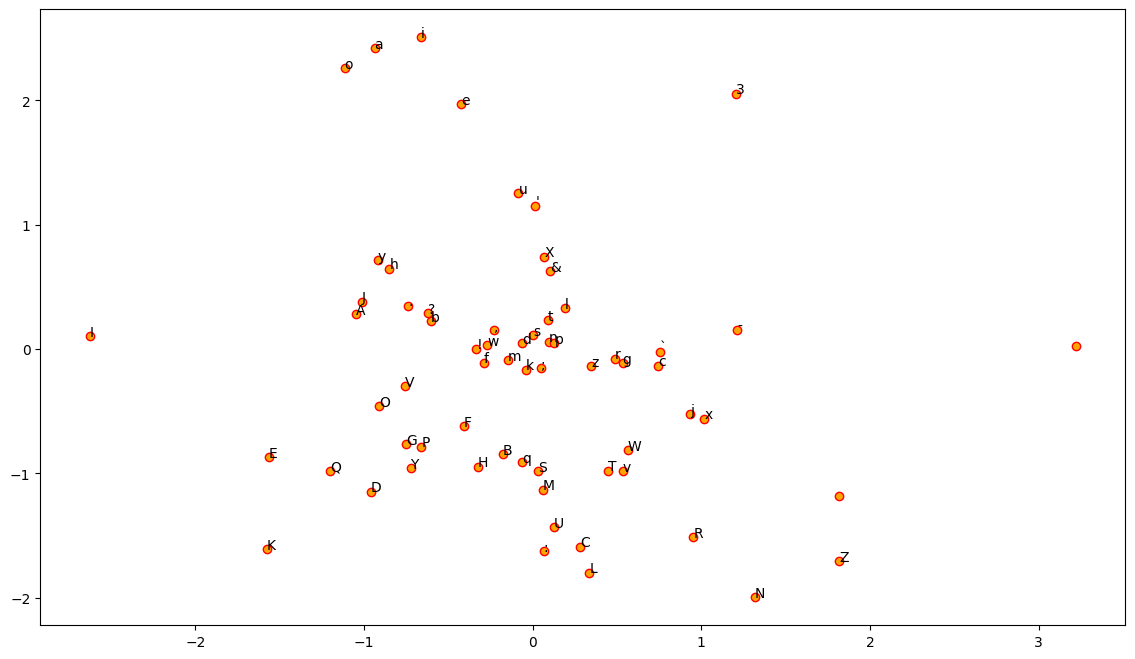

In [ ]:
#| eval: false
plt.figure(figsize=(14, 8))
plt.scatter(T[ :, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(vocab, T[:, 0], T[:, 1]):
  plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')

In [ ]:
#| hide
!nbdev_export
#import nbdev; nbdev.nbdev_export()